In [1]:
# 
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
# Импорт библиотеки seaborn для построения парных графиков
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2023-06-13 00:36:23.591694: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 00:36:25.003678: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 00:36:25.009662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 00:36:29.987775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
# Загружаем данные из репозитория в локальную папку компьютера.
dataset_path = keras.utils.get_file("/home/lawrenceub/VSCodeProjects/PythonLaba7.3/auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/lawrenceub/VSCodeProjects/PythonLaba7.3/auto-mpg.data'

In [3]:
column_names = ['Расход топлива','Кол-во цилиндров','Объем двигателя','Л.с.','Вес',
'Разгон до 100 км/ч', 'Год выпуска', 'Страна выпуска']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
#  Вывод последних 5 строк
dataset.tail()

,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,Страна выпуска
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# подготовка данных 
dataset.isna().sum()

Расход топлива        0
Кол-во цилиндров      0
Объем двигателя       0
Л.с.                  6
Вес                   0
Разгон до 100 км/ч    0
Год выпуска           0
Страна выпуска        0
dtype: int64

In [5]:
# нулевые удалили
dataset = dataset.dropna()

# Извлечение столбца с удалением его из набора
origin = dataset.pop('Страна выпуска')

# Добавление новых столбцов
dataset['США'] = (origin == 1)*1.0
dataset['Европа'] = (origin == 2)*1.0
dataset['Япония'] = (origin == 3)*1.0
#  Вывод последних 5 строк
dataset.tail()

,Расход топлива,Кол-во цилиндров,Объем двигателя,Л.с.,Вес,Разгон до 100 км/ч,Год выпуска,США,Европа,Япония
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


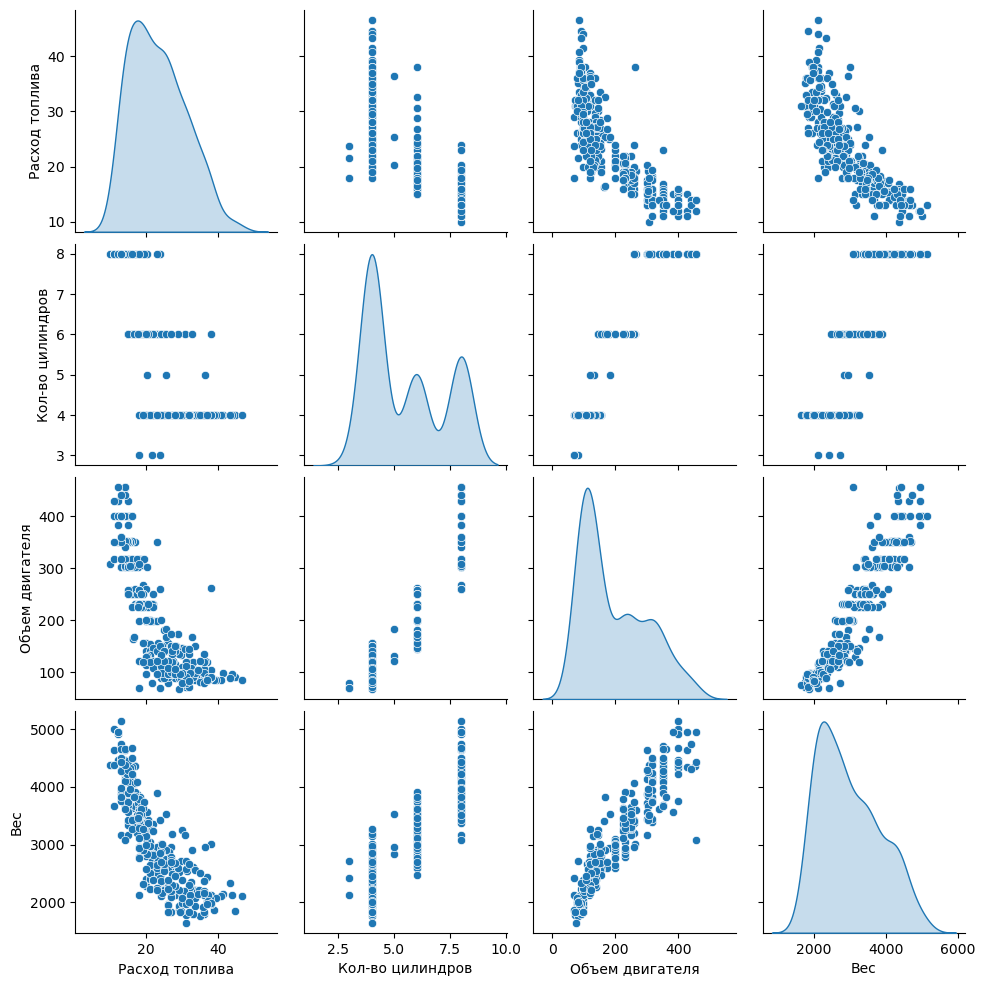

In [6]:
# Разделение данных на тернировочные и проверочные
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["Расход топлива", "Кол-во цилиндров", "Объем двигателя", "Вес"]], diag_kind="kde")

In [7]:
#Вывод общей статистики:
train_stats = train_dataset.describe()
train_stats.pop("Расход топлива")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Кол-во цилиндров,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Объем двигателя,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Л.с.,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Вес,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Разгон до 100 км/ч,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Год выпуска,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
США,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Европа,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Япония,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
#Необходимо отделить целевые значения от характеристик и использовать эти значения для обучения модели регрессии
# Извлечение целевого столбца с удалением из набора

train_labels = train_dataset.pop('Расход топлива')
test_labels = test_dataset.pop('Расход топлива')

# Функция нормализации
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# Нормализация данных
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# построение модели

from tensorflow.keras import models
def build_model():
  model = keras.Sequential([
  layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
  layers.Dense(64, activation=tf.nn.relu),
  layers.Dense(1)
  ])

#  optimizer = tf.train.RMSPropOptimizer(0.001)
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
# mse - mean_squared_error (средняя квадратическая ошибка)
# mae - mean_absolute_error (средняя абсолютная ошибка)
  model.compile(loss='mse',
optimizer=opt,
metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [9]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 325ms/step


array([[-8.8722564e-02],
       [-1.5543319e-02],
       [-1.6919294e-01],
       [ 2.5475696e-02],
       [ 1.9626319e-04],
       [ 7.7449024e-02],
       [-3.7663341e-02],
       [-3.4320879e-01],
       [ 2.6045170e-02],
       [-1.8683858e-01]], dtype=float32)

In [10]:
# Обучение модели
# Выведем прогресс обучения в виде точек после каждой завершенной эпохи
class PrintDot(keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs):
    # Перевод строки после 100 эпох
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
# validation_split = 0.2 - 20% данных отводится на проверку
history = model.fit(
 normed_train_data, train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose=0,
 callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [11]:
# Выполним визуализацию процесса обучения при помощи статистики из объекта history:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#  Вывод последних 5 строк
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.609543,1.018156,2.609543,7.385050,2.062594,7.385050,995
996,2.828387,1.114152,2.828387,8.073537,2.170535,8.073537,996
997,2.579318,1.005756,2.579318,7.951930,2.163078,7.951930,997
998,2.629621,1.042111,2.629621,8.052084,2.109458,8.052084,998
999,2.805748,1.046993,2.805748,8.624509,2.259052,8.624509,999


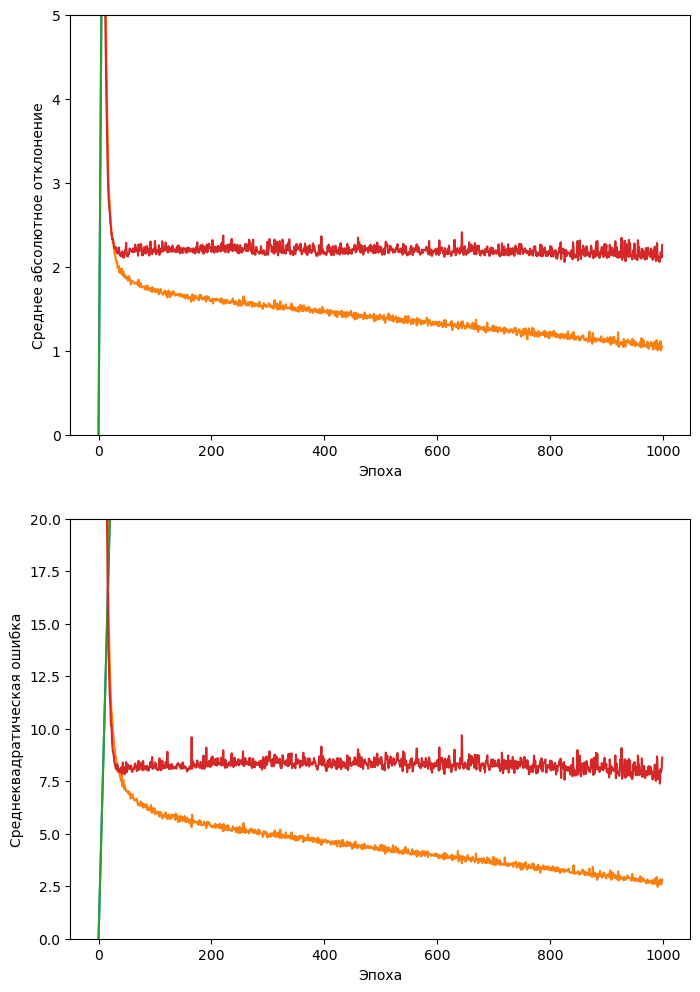

In [12]:
# Функция визуализации процесса обучения 
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднее абсолютное отклонение')
    #plt.plot (hist['epoch']), hist['mae'], label= 'Ошибка при обучении')
    plt.plot (hist['epoch'])
    plt.plot (hist['mae'])
    plt.plot(label='Ошибка при обучении')
    # plt.plot (hist['epoch'], hist['val_mae'], label = 'Ошибка при проверке')
    plt.plot (hist['epoch'])
    plt.plot (hist['val_mae'])
    plt.plot(label='Ошибка при проверке')
    plt.ylim([0,5])
    #plt.legend()
    plt.subplot(2,1,2)
    plt.xlabel('Эпоха')
    plt.ylabel('Среднеквадратическая ошибка')
    #plt.plot(hist['epoch'], hist['mse'], label='Ошибка при обучении')
    plt.plot(hist['epoch'])
    plt.plot(hist['mse'])
    plt.plot(label='Ошибка при обучении')
    #plt.plot(hist['epoch'], hist['val_mse'], label = 'Ошибка при проверке')
    plt.plot(hist['epoch'])
    plt.plot(hist['val_mse'])
    plt.plot(label='Ошибка при проверке')
    plt.ylim([0,20])
    #plt.legend()
    plt.show()

plot_history(history)


....................................................................................................
..................................................

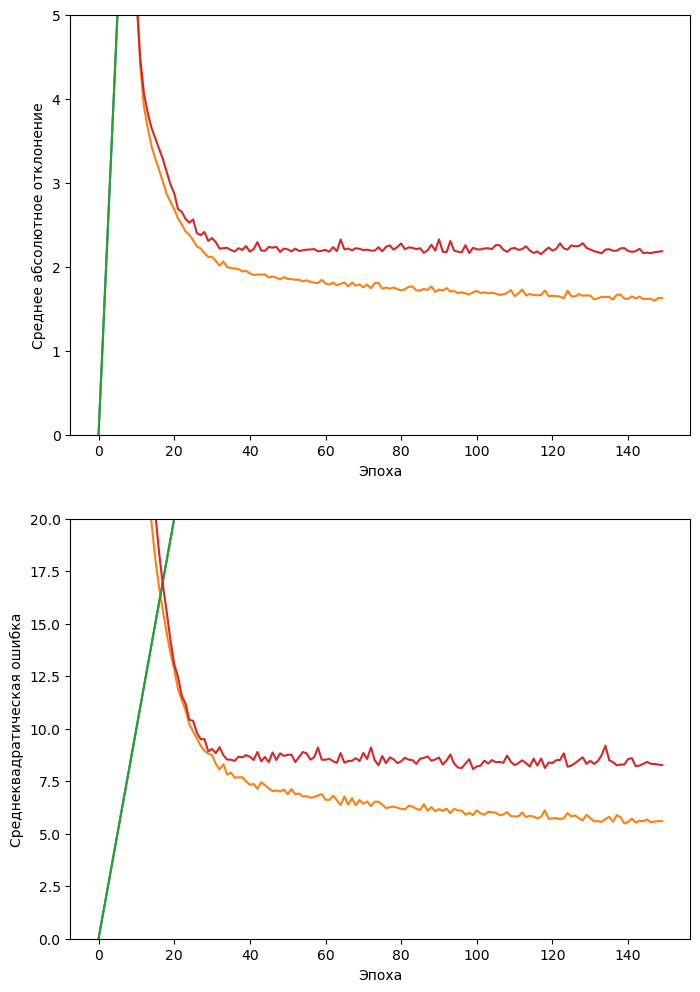

In [13]:
model = build_model()

# Параметр patience определяет количество эпох, которые можно пропустить без улучшений
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [26]:
# На следующем шаге обученная модель проверяется на наборе данных для проверки:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Среднее абсолютное отклонение на проверочных данных: {:5.2f} галлон на милю".format(mae))
print("Потери: {:5.2f}".format(loss))
print("Средняя квадратическая ошибка на проверочных данных: {:5.2f}".format(mse))

Среднее абсолютное отклонение на проверочных данных:  1.84 галлон на милю
Потери:  5.40
Средняя квадратическая ошибка на проверочных данных:  5.40


3/3 [==============================] - 0s 2ms/step


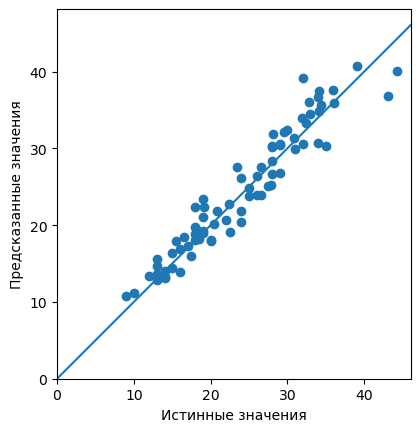

In [15]:
# Выполним предсказания показателей расхода топлива, используя набор наши проверочные данные:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

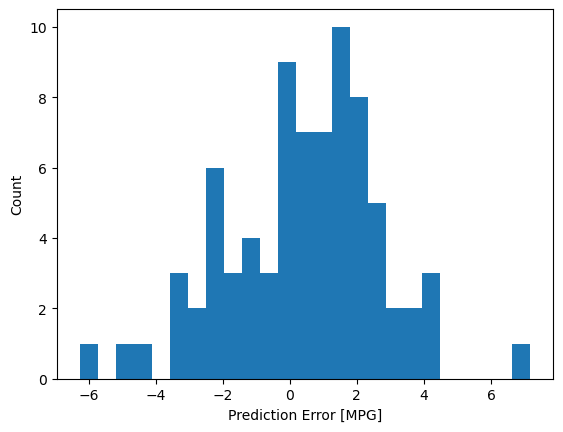

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [17]:
model.save('model_baza.h5')

baza_model = keras.models.load_model('model_baza.h5')
    #loss, acc = baza_model.evaluate(test_dataset, test_labels)
    #print("Базовая модель, точность: {:5.2f}%".format(100*acc))
    #print("Базовая модель, потери: {:5.2f}%".format(100*loss))